In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [11]:
df=pd.read_csv('italy.csv')
print(len(df.columns))
Italy_regions=['Lombardia','Emilia-Romagna','Piemonte','Veneto','Toscana','Marche','Liguria','Abruzzo',
               'Umbria','Molise','Campania','Lazio','Valle d\'Aosta','Puglia','Basilicata','Campania']
populations=[10060000.0,4459000.0,4356000.0,4906000.0,3730000.0,1525000.0,1551000.0,
            1312000.0,882015.0,305617.0,5802000.0,5879000.0,125666.0,4029000.0,562869.0,5802000.0]
#target='Lombardia'
neighbors={}
targets=['Lombardia','Emilia-Romagna','Lazio','Piemonte','Campania','Molise','Umbria']
regions1=['Emilia-Romagna','Piemonte','Veneto']
regions2=['Toscana','Marche','Liguria','Piemonte','Lombardia','Veneto']
regions3=['Abruzzo','Toscana','Umbria','Molise','Campania']
regions4=['Liguria','Valle d\'Aosta','Lombardia','Emilia-Romagna']#Piemonte
regions5=['Lazio','Molise','Puglia','Basilicata']#Campania
regions6=['Lazio','Abruzzo','Puglia','Campania']#Molise
regions7=['Toscana','Marche','Lazio']#Umbria
neighbors['Lazio']=regions3
neighbors['Lombardia']=regions1
neighbors['Emilia-Romagna']=regions2
neighbors['Piemonte']=regions4
neighbors['Campania']=regions5
neighbors['Molise']=regions6
neighbors['Umbria']=regions7
pops={}
vals=df['Lombardia'].values
split_num=int(vals.shape[0]*0.70)
for i, region in enumerate(Italy_regions):
    pops[region]=populations[i]
p=3
X_node={}
X_edge={}
Y_vals={}
length=0
split_num=0
for target in targets:
    vals=df[target].values
    length=vals.shape[0]-p
    split_num=int(vals.shape[0]*0.70)
    X=[]
    Y=[]
    for i in range(p,vals.shape[0]):
        feature=[]
        label=[vals[i]/pops[target]]
        for j in range(1,p+1):
            feature.append(vals[i-j]/pops[target])
        X.append(feature)
        Y.append(label)
    train_node=np.asarray(X,dtype=np.float32)
    train_edge=np.zeros((train_node.shape[0],train_node.shape[1]),dtype=np.float32)
    states=neighbors[target]
    for state in states:
        matrix=[]
        evals=df[state].values
        for i in range(p,vals.shape[0]):
            temp=[]
            for j in range(1,p+1):
                temp.append(evals[i-j]/(pops[state]*len(states)))
            matrix.append(temp)
    train_edge+=np.asarray(matrix,dtype=np.float32)
    


    X_node[target+'_train']=train_node[:split_num,:]
    X_node[target+'_test']=train_node[split_num:,:]
    X_edge[target+'_train']=train_edge[:split_num,:]
    m,n=X_edge[target+'_train'].shape
    X_edge[target+'_train']=X_edge[target+'_train'].reshape((m,n,1))
    X_edge[target+'_test']=train_edge[split_num:,:]
    m,n=X_edge[target+'_test'].shape
    X_edge[target+'_test']=X_edge[target+'_test'].reshape((m,n,1))
    Y=np.asarray(Y,dtype=np.float32) 
    Y_vals[target+'_train']=Y[:split_num,:]
    Y_vals[target+'_test']=Y[split_num:,:]
    
T=np.arange(length,dtype=np.float32)

T_train=T[:split_num]
T_test=T[split_num:]
print(split_num)
print(X_edge['Lazio_test'].shape)
print(T_test.shape)
print(X_node['Lazio_test'].shape)

20
81
(32, 3, 1)
(32,)
(32, 3)


In [21]:
tf.reset_default_graph()
alphas={}
beta_1s={}
beta_2s={}
gammas={}
#Lombardia, Emilia-Romagna, Lazio
for target in targets:
    alphas[target]=tf.Variable(0.8,trainable=True) #,0.8,0.8,0.8,0.8,0.8
    beta_1s[target]=tf.Variable(0.3,trainable=True) #,0.3,0.3,0.3,0.3,0.3
    beta_2s[target]=tf.Variable(0.15,trainable=True) #,0.22,0.22,0.15,0.15,0.15
    gammas[target]=tf.Variable(0.15,trainable=True) #,0.15,0.15,0.09,0.15,0.1
cell=tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=nu) for nu in [20,40,20]])
LSTM_cell=tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=nu) for nu in [20,40,20]])
Ie={}
loss={}
node_features={}
edge_features={}
Y_t={}

T=tf.placeholder(dtype=tf.float32,shape=[None])
for target in targets:
    node_features[target]=tf.placeholder(dtype=tf.float32,shape=[None,p])
    edge_features[target]=tf.placeholder(dtype=tf.float32,shape=[None,p,1])
    Y_t[target]=tf.placeholder(dtype=tf.float32,shape=[None,1])


alpha=alphas[target]
beta_1=beta_1s[target]
beta_2=beta_2s[target]
gamma=gammas[target]
#train_node=node_features[target]
train_node=tf.placeholder(dtype=tf.float32,shape=[None,p])
#train_edge=edge_features[target]
train_edge=tf.placeholder(dtype=tf.float32,shape=[None,p,1])
Y=tf.placeholder(dtype=tf.float32,shape=[None,1])

edge_output, _ = tf.nn.dynamic_rnn(  # (N, T, D)
                    cell=cell,
                    dtype=tf.float32,
                    #inputs=train_edge.reshape((train_edge.shape[0],train_edge.shape[1],1))
                    inputs=train_edge
    )
Ie=tf.layers.dense(edge_output[:,-1,:],units=1,activation=tf.tanh)
Ie=tf.reshape(Ie,shape=[tf.shape(train_edge)[0]])
I1=(1-gamma)*train_node[:,0]
I2=(beta_1*train_node[:,0]+beta_2*Ie)*(alpha-train_node[:,0]-gamma*T/(p+1)*tf.reduce_sum(train_node,1))
Y_hat=I1+I2

loss=tf.reduce_mean(tf.square(Y-Y_hat))
tv=tf.trainable_variables()  
regularization_cost=0.0005*tf.reduce_sum([tf.nn.l2_loss(v) for v in tv])
#weights=[v for v in tv if 'rnn' in v.name]
#l1_regularizer = tf.contrib.layers.l1_regularizer(scale=10e-10, scope=None)
#regularization_cost = tf.contrib.layers.apply_regularization(l1_regularizer, weights)
train_op1=tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
train_op2=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    

In [22]:
target='Lombardia'
train_n=X_node[target+'_train']
train_e=X_edge[target+'_train']
Y_train=Y_vals[target+'_train']
Y_test=Y_vals[target+'_test']
test_node=X_node[target+'_test']
test_edge=X_edge[target+'_test']
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    for i in range(20):
        _,Loss=sess.run([train_op1,loss],feed_dict={train_node:train_n,train_edge:train_e,Y:Y_train,T:T_train})
        print(Loss)
    for i in range(20):
        _,Loss=sess.run([train_op2,loss],feed_dict={train_node:train_n,train_edge:train_e,Y:Y_train,T:T_train})
        print(Loss)
    prediction_train=sess.run(Y_hat,feed_dict={train_node:train_n,train_edge:train_e,Y:Y_train,T:T_train})
    prediction_test=sess.run(Y_hat,feed_dict={train_node:test_node,train_edge:test_edge,Y:Y_test,T:T_test})

3.225891e-06
3.1164647e-05
3.9485913e-06
7.5944026e-06
1.2403512e-05
9.52503e-06
4.90567e-06
3.0780766e-06
4.4477288e-06
6.028129e-06
5.778615e-06
4.5780153e-06
3.5542207e-06
3.0459469e-06
2.9288385e-06
2.9976723e-06
3.1072782e-06
3.1839907e-06
3.2041594e-06
3.1721645e-06
3.1042418e-06
2.9786904e-06
2.8875104e-06
2.8292118e-06
2.79895e-06
2.7899482e-06
2.7943881e-06
2.8045336e-06
2.8140835e-06
2.8190939e-06
2.8180705e-06
2.81136e-06
2.800375e-06
2.7869191e-06
2.7727287e-06
2.7592398e-06
2.7474562e-06
2.7379137e-06
2.7307156e-06
2.7255933e-06


32


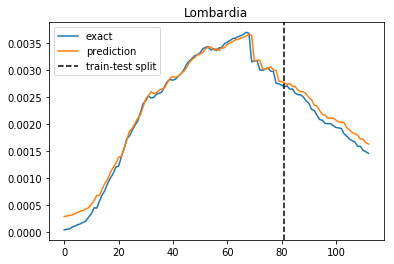

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
prediction=np.concatenate((prediction_train,prediction_test),axis=0)
y=np.concatenate((Y_train,Y_test),axis=0)
print(prediction_test.shape[0])
plt.plot(y,label='exact')
plt.plot(prediction,label='prediction')
plt.axvline(x=split_num,label='train-test split',linestyle='dashed',color='black')
plt.title(target)
plt.legend()
plt.show()